In [1]:

import math, time, random, datetime


import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')


from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# ML
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [3]:
train.info
train.describe
train.head(10)# данные для тренировки

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
test.head(5)#данные для теста

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
gender_submission.head(5)# это пример нашего финального прогноза,здесь нам нужно на основе тренировки можели подставить значения выжил,иинет

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Интерпритация данных
Survival: 0 = No, 1 = Yes


pclass (Класс билета ( 1 класс находился наверху, 3-й внизу)): 1 = 1st, 2 = 2nd, 3 = 3rd

sex(пол): Sex

Age: Age in years

sibsp: number of siblings/spouses aboard the Titanic( количество родственников на борту)

parch: number of parents/children aboard the Titanic( кол-во детей/родителей на борту)

ticket: Ticket number

fare: Passenger fare( стоимость билета)

cabin: Cabin number

embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton****( в каком порту погружались)

Для начала нужно проанализировать данные, узнать где есть Nan.

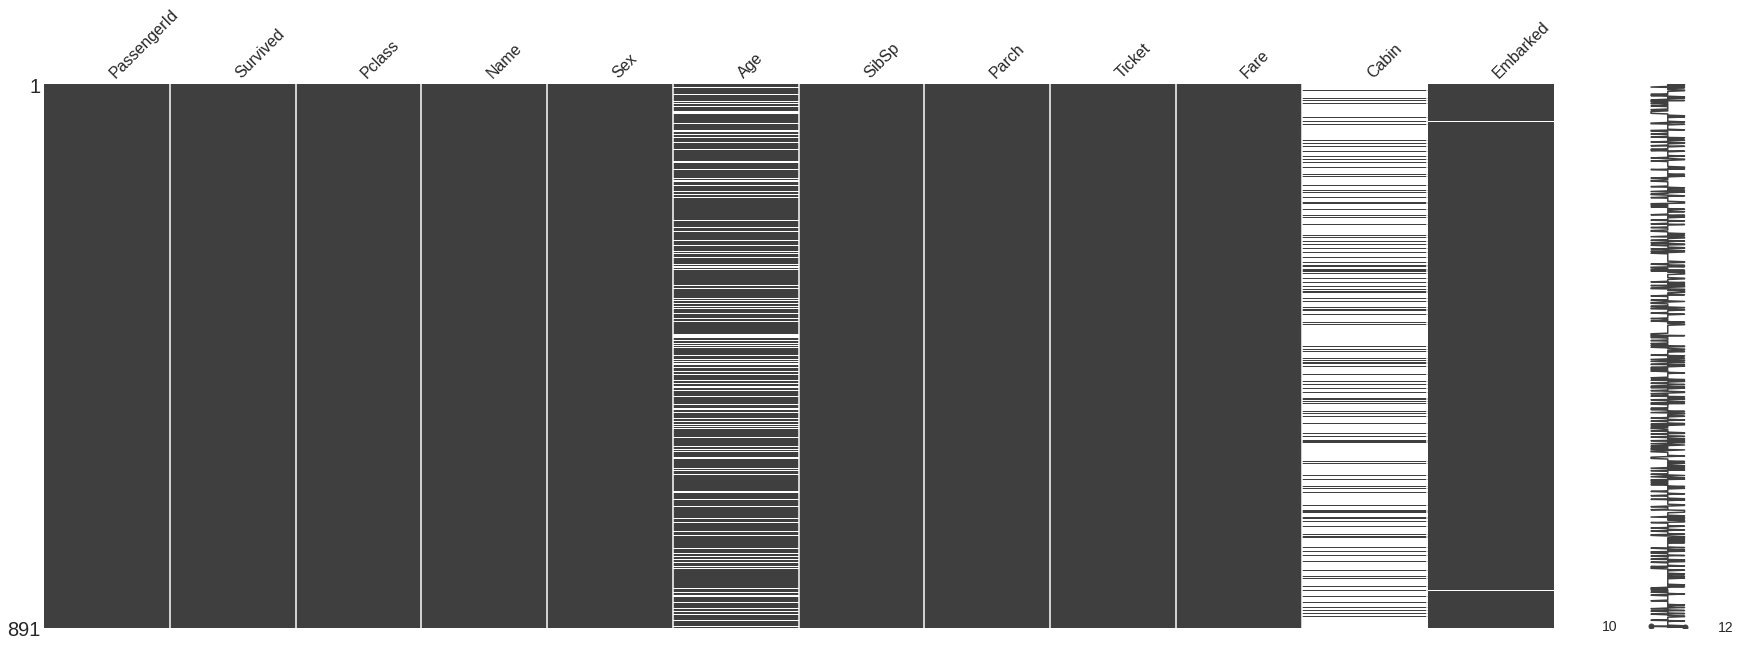

In [6]:
missingno.matrix(train, figsize = (30,10))

Если мы хотим посмотреть в числах количесвто Nan  согласно колонкам.

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Сделаем еще два датафрейма для дискретных и непрерывных данных.


In [8]:
df_bin = pd.DataFrame() # дискретные
df_con = pd.DataFrame() # непрерывные

In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Мы последовательно рассмотрим каждый столбец и посмотрим, какие из них использовать в наших первых моделях. Некоторым может потребоваться больше предварительной обработки, чем другим, чтобы подготовиться.

**Таргет: выжил
Описание: выжил пассажир или нет. 
Ключ: 0 = не выжил, 1 = выжил n\
Это переменная, которую мы хотим, чтобы наша модель машинного обучения предсказывала на основе всех остальных.**

0    549
1    342
Name: Survived, dtype: int64


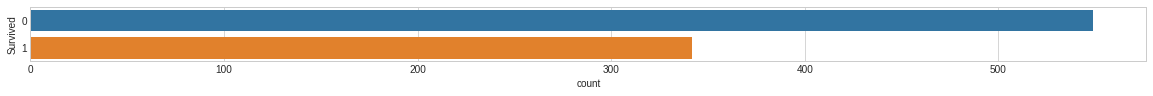

In [10]:
fig = plt.figure(figsize=(20,1))# построим график,который покажет,сколько выжило пассажиров,а сколько нет.
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

Как мы видим,большинство пассажиров погибло. Это печально. Добавим их к нашим двум датафреймам.



In [11]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

Сначала мы рассмотрим распределение каждой функции, если сможем понять, какое распространение существует в наборе данных. Например, если есть значения, которые полностью выходят за рамки распределения, мы можем не захотеть включать их в нашу модель.
Это нужно для исключения выбросов, другими словами повысить точность нашей модели.

# **2) Класс билета**

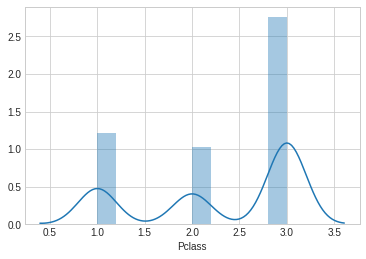

In [12]:
sns.distplot(train.Pclass)

In [13]:

df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

# **3)Feature: Имя**
> 

In [14]:
train.Name.value_counts()

Sivic, Mr. Husein                                           1
Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)    1
Karlsson, Mr. Nils August                                   1
Taussig, Mr. Emil                                           1
Meyer, Mrs. Edgar Joseph (Leila Saks)                       1
                                                           ..
Mockler, Miss. Helen Mary "Ellie"                           1
Jenkin, Mr. Stephen Curnow                                  1
Murphy, Miss. Margaret Jane                                 1
Kiernan, Mr. Philip                                         1
Fynney, Mr. Joseph J                                        1
Name: Name, Length: 891, dtype: int64

Каждая строка имеет уникальное имя. \
Это эквивалентно идентификатору пассажира. \
Из-за большого количества разных имен и для того, чтобы EDA оставалась быстрой, мы не будем использовать эту переменную.



# 4)Пол(Sex)

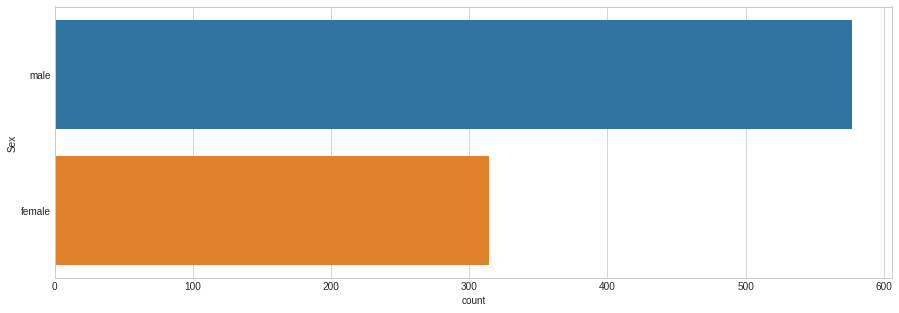

In [15]:
plt.figure(figsize=(15, 5))
sns.countplot(y="Sex", data=train);


Как мы видим мужчин на борту больше,почти что в два раза.


In [16]:

# проверим на нулы
train.Sex.isnull().sum()

0

Поскольку это уже двоичная переменная (мужская или женская), давайте добавим ее прямо в наши подмножества фреймов данных

In [17]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 для мужчины,1 для женщины 

df_con['Sex'] = train['Sex']


In [18]:
np.corrcoef(df_bin['Sex'],df_bin['Survived'])# корреляция между мужичнами и женщинами в плане выживания.



array([[1.        , 0.54335138],
       [0.54335138, 1.        ]])

##### 5)Age


In [19]:
train.Age.isnull().sum()

177

почти что 25 процентов датасета имеют значения нулл в этой колонке

6)Sib- количество братьев и сестер на борту титаника.

In [20]:
train.SibSp.isnull().sum()

0

In [21]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [22]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

# 7) Parch (родители и дети)
Описание: Количество родителей / детей у пассажира на борту Титаника. Поскольку эта функция похожа на SibSp, мы проведем аналогичный анализ.

In [23]:
train.Parch.value_counts()
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']


# 8)Ticket
Номер билета посадочного пассажира.

In [24]:
train.Ticket.isnull().sum()

0

In [25]:
train.Ticket.value_counts()

CA. 2343              7
347082                7
1601                  7
3101295               6
CA 2144               6
                     ..
373450                1
2685                  1
2695                  1
SOTON/O.Q. 3101311    1
2003                  1
Name: Ticket, Length: 681, dtype: int64

  681 уникальных значений - это пока слишком много. Поэтому мы не будем использовать Ticket в наших подмножествах фреймах.

# 9)Fare


Сколько стоил билет

In [26]:
train.Fare.dtype #тип fare флоат , стоит отметить


dtype('float64')

In [27]:
len(train.Fare.unique())

248

Поскольку Fare является числом с плавающей запятой, давайте добавим его как есть в наш непрерывный субфрейм данных, но чтобы добавить его в наш категориальный субфрейм данных, мы разрежем его на отрезки

In [28]:
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # дискретный

In [29]:

# Отрезки
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

# 10) Cabin(каюта)
Номер каюты, в которой остановился пассажир.

In [30]:
train.Cabin.isnull().sum()

687

In [31]:
train.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
D              3
              ..
C104           1
A19            1
B79            1
D46            1
B71            1
Name: Cabin, Length: 147, dtype: int64

Поскольку существует слишком много пропущенных значений, мы не будем использовать Cabin для наших исходных моделей и не будем добавлять его в наши подфреймы данных.

# 11) Embarked(Отправление) **
Порт, в котором пассажир сел на Титаник. Обозначения: C = Шербур, Q = Квинстаун, S = Саутгемптон

10) 

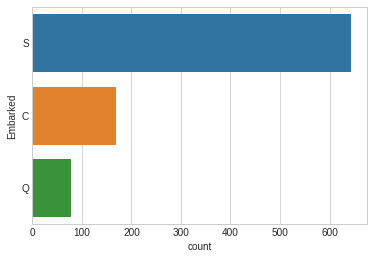

In [32]:
sns.countplot(y='Embarked', data=train);

Большинство село в Саутгемптоне

In [33]:
train.Embarked.isnull().sum()

2

In [34]:
train.Embarked.isnull().sum()

2

In [35]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [36]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


# Второй шаг-Редактируем фичи



Теперь у нас есть два подфрейма данных. Мы можем закодировать функции, чтобы они были готовы к использованию с нашими моделями машинного обучения. 

In [37]:
df_bin.head()


,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [38]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [39]:
df_con.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S
5,0,3,male,0,0,8.4583,Q
6,0,1,male,0,0,51.8625,S
7,0,3,male,3,1,21.0750,S
8,1,3,female,0,2,11.1333,S
9,1,2,female,1,0,30.0708,C


In [40]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [41]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [42]:
df_con_enc.head(20)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


# 3 шаг. Построение моделей.

In [43]:
selected_df = df_con_enc#выберем дф для первых прогнозов


In [44]:
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [45]:
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

Дело техники: делим нашу дату

In [46]:
X_train.shape

(889, 11)

In [47]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [48]:
y_train.shape

(889,)

In [49]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Определим  функцию, обучающую наши множественные модели


> Поскольку мы будем много использовать sklearn и загружать практически одинаковые входные данные. Чтобы избежать много кода , мы будем работать с подгонкой модели и возвращать оценки точности.

In [50]:


def fit_ml_algo(algo, X_train, y_train, cv):
    
    # фит модели
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # C V
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    #  точность C-V
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

# ***Логистическая регрессия (Logistic regression)******

In [51]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:02.430632


# Метод k-ближайших соседей (k-nearest neighbors algorithm)

In [52]:
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.142651


# Наивный байесовский классификатор (Naive Bayes classifier)

In [53]:
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.059053


# Метод опорных векторов (Support vector machine)

In [54]:
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.18
Accuracy CV 10-Fold: 76.6
Running Time: 0:00:00.254291


# Дерево принятия решений в обучении (Decision tree learning)

In [55]:
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.2
Running Time: 0:00:00.083524


# Gradient Boost Trees

In [56]:
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:00.747598


# CatBoost Algorithm (сделанный Яндексом))


In [57]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [58]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [59]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

Это означает, что Catboost понял, что все переменные, кроме Fare, можно рассматривать как categorical.

In [60]:
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)#объединием обучающие данные и категориальные метки функций

In [61]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.009797


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6862830	total: 56ms	remaining: 56s
1:	learn: 0.6809444	total: 58.1ms	remaining: 29s
2:	learn: 0.6751692	total: 60.5ms	remaining: 20.1s
3:	learn: 0.6689060	total: 62.8ms	remaining: 15.6s
4:	learn: 0.6632144	total: 65ms	remaining: 12.9s
5:	learn: 0.6576488	total: 66.8ms	remaining: 11.1s
6:	learn: 0.6544441	total: 67.7ms	remaining: 9.61s
7:	learn: 0.6490635	total: 69.9ms	remaining: 8.67s
8:	learn: 0.6443241	total: 72.3ms	remaining: 7.96s
9:	learn: 0.6395935	total: 74.5ms	remaining: 7.37s
10:	learn: 0.6345186	total: 76.3ms	remaining: 6.86s
11:	learn: 0.6305316	total: 78.3ms	remaining: 6.45s
12:	learn: 0.6275610	total: 79.4ms	remaining: 6.03s
13:	learn: 0.6225020	total: 81.5ms	remaining: 5.74s
14:	learn: 0.6179503	total: 83.4ms	remaining: 5.47s
15:	learn: 0.6140480	total: 84.5ms	remaining: 5.2s
16:	learn: 0.6100034	total: 86.1ms	remaining: 4.98s
17:	learn: 0.6049646	total: 88.3ms	remaining: 4.82s
18:	learn: 0.6025760	total: 89.2ms	remaining: 4.61s
19:	learn: 0.5998630	total: 90.

In [1]:

# время
start_time = time.time()


cv_params = catboost_model.get_params()

# кросс валидация 10 раз
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# время кэтбуста
catboost_time = (time.time() - start_time)


acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

NameError: name 'time' is not defined

In [63]:
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:06:07.657486


In [2]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

NameError: name 'pd' is not defined

CV метрика показывает,что модель cat boost  намного лучше .

Регулярная метрика точности

In [65]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

NameError: name 'acc_cv_sgd' is not defined

# Важность параметров(features)

In [4]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    

In [3]:


feature_importance(catboost_model, X_train)

NameError: name 'feature_importance' is not defined

Важность разных параметров. Как мы видим Пол и цена билета играли важную роль.

Финальный тест

In [68]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [69]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [70]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [71]:
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [72]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [73]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [74]:
predictions[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [5]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions #наш прогноз моедли 
submission.head()

NameError: name 'pd' is not defined

In [76]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [77]:
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [78]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [79]:
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [ ]:
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

Результаты введем в отдельный CSV файл
